In [1]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tables
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [2]:
embedder = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [3]:
def build_features(x):
    corpus_embeddings = embedder.encode(x['comment'].tolist(), convert_to_tensor=True)
    s = torch.mean(corpus_embeddings, axis = 0)
    x['emb'] = [torch.mean(corpus_embeddings, axis = 0) for i in range(5)]
    return x[:1] #torch.mean(corpus_embeddings, axis=0)

In [4]:
CSV_PATH = "flickr30k_images/results.csv"
results = pd.read_csv(CSV_PATH,error_bad_lines=False,sep="|")
results = results[:1000]

In [5]:
results.columns = [i.strip() for i in results.columns]

In [7]:
df = pd.DataFrame(results[['image_name','comment']],columns=['image_name','comment'])
df = df.groupby("image_name").progress_apply(build_features)

100%|██████████| 200/200 [00:28<00:00,  7.09it/s]


In [9]:
df = pd.DataFrame(df[['image_name','emb']],columns=['image_name','emb'])
df = df.reset_index(drop=True)

In [10]:
df.to_hdf('data.h5', key='df', mode='w')

/home/yamen/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['image_name', 'emb'], dtype='object')]

  pytables.to_hdf(


In [11]:
IMAGES_PATH = 'flickr30k_images/flickr30k_images/'

In [12]:
df = pd.read_hdf('data.h5')

In [13]:
df

,image_name,emb
0,1000092795.jpg,"[tensor(0.2275), tensor(-0.0328), tensor(0.094..."
1,10002456.jpg,"[tensor(-0.0056), tensor(0.0371), tensor(0.231..."
2,1000268201.jpg,"[tensor(0.2530), tensor(-0.1616), tensor(0.033..."
3,1000344755.jpg,"[tensor(-0.0125), tensor(-0.1501), tensor(0.11..."
4,1000366164.jpg,"[tensor(0.0984), tensor(-0.1994), tensor(-0.10..."
...,...,...
195,1066252238.jpg,"[tensor(-0.0041), tensor(0.0873), tensor(-0.08..."
196,1066831905.jpg,"[tensor(0.0444), tensor(0.0448), tensor(0.2289..."
197,106691539.jpg,"[tensor(0.1686), tensor(-0.0280), tensor(-0.16..."
198,1067180831.jpg,"[tensor(0.1006), tensor(0.1095), tensor(0.0324..."


In [14]:
embeddings = torch.cat([i.unsqueeze(0) for i in df['emb'].values.tolist()], axis=0)

In [24]:
query = 'sea'

In [25]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(df))
query_embedding = embedder.encode(query, convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.pytorch_cos_sim(query_embedding, embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

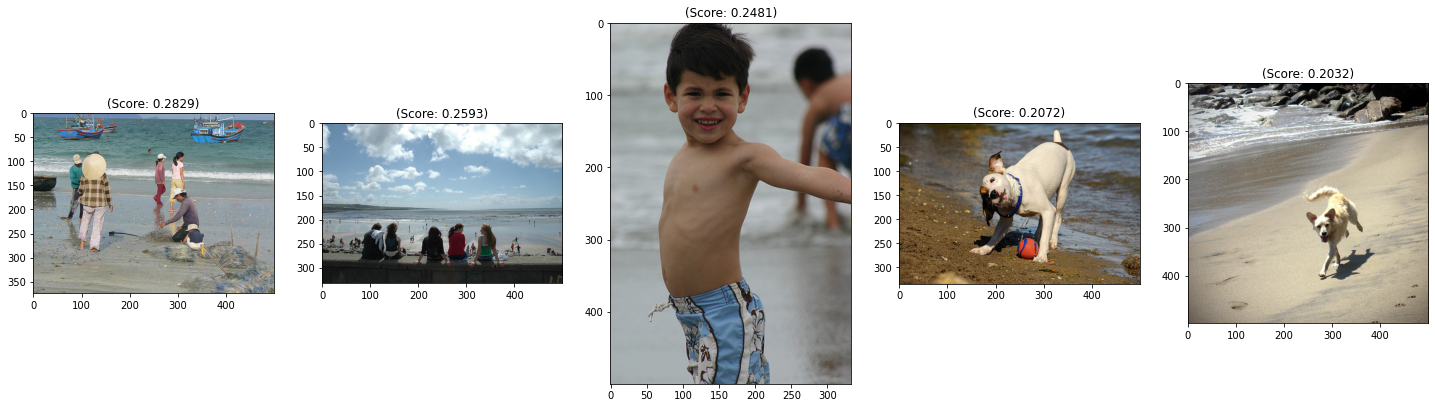

In [26]:
fig, axs = plt.subplots(1,5,figsize=(25, 20))
for ax, score, idx in zip(axs, top_results[0], top_results[1]):
    img = mpimg.imread(IMAGES_PATH + df['image_name'].values[idx])
    ax.imshow(img)
    ax.set_title("(Score: {:.4f})".format(score))

plt.show()